In [27]:
import os
import sys
import time
import yaml
import pandas as pd
import numpy as np
import re

with open('../../config.local.yaml', 'r') as f:
    local_config = yaml.safe_load(f)

LOCAL_PATH = local_config['LOCAL_PATH']

sys.path.append(os.path.join(LOCAL_PATH, "src/python"))

import data_tools as dt
import writing_tools as wt
from utils import parse_casenum
from llm import get_embeddings

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from IPython.core.display import HTML
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 11

os.environ['LOKY_MAX_CPU_COUNT'] = '1' # because of windows core count warning

rng = np.random.default_rng(12898)

N_CLUSTERS = 3
N_COMPONENTS = 10


In [28]:
dfa = dt.get_agenda_items(verbose=False)

In [29]:
# Get the agenda item embeddings
texts = dfa['project_summary'].tolist()
embeddings = get_embeddings(texts)

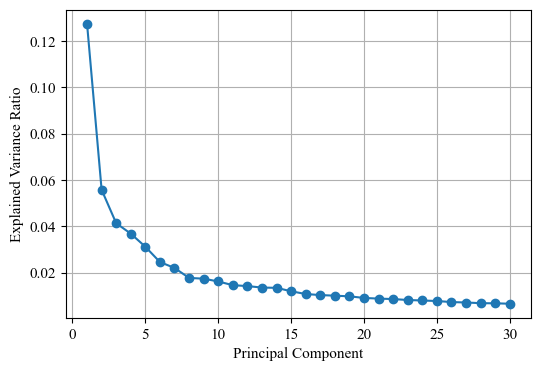

In [30]:
# PCA scree plot
pca = PCA()
pca.fit(embeddings)
explained_variance = pca.explained_variance_ratio_[0:30]
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
#plt.title('Scree Plot of PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
filename = os.path.join(LOCAL_PATH, 'figures', 'fig_scree_plot.pdf')
plt.savefig(filename, bbox_inches='tight')
plt.show()


In [31]:
# Reduce embeddings to 10 dimensions
pca = PCA(n_components=N_COMPONENTS)
embeddings_reduced = pca.fit_transform(embeddings)

In [32]:
# Cluster into 3 clusters using kmeans
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
kmeans.fit(embeddings_reduced)
dfa['cluster'] = kmeans.labels_
dfa['cluster'].value_counts()

cluster
0    543
1    118
2     69
Name: count, dtype: int64

In [33]:
# Show random examples from each cluster
for cluster in dfa['cluster'].unique():
    print(f"Cluster {cluster}:")
    cluster_items = dfa[dfa['cluster'] == cluster]
    sample_items = cluster_items.sample(3)
    for idx, row in sample_items.iterrows():
        print("---")
        print(row['project_summary'])
    print("======")
    print("")

Cluster 0:
---
The proposed project involves the demolition of an existing 40,000 square-foot film storage building and its associated parking lot and truck rental business. In its place, a seven-story storage building will be constructed, consisting of 127,868 square feet of self-storage, 39,510 square feet of temperature-controlled film and media storage, and 1,100 square feet of leasing uses, totaling 168,478 square feet of floor area. The building will be 75 feet tall with a floor area ratio of 3:1. The project includes 47 automobile parking spaces and 40 bicycle parking spaces. It requires the export of approximately 5,200 cubic yards of soil and proposes the removal of ten trees, with 47 new trees to be planted. The requested actions include consideration of the Mitigated Negative Declaration, a Zone Change and Height District Change, a Conditional Use Permit, a Site Plan Review, and a Waiver of Dedication and/or Improvements.
---
The District NoHo Project is a multi-phased, mixe

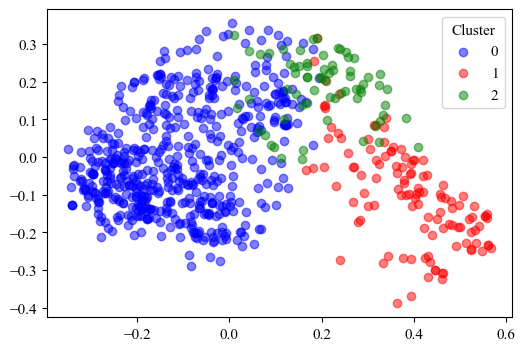

In [34]:
# Scatter plot colored by cluster
plt.figure(figsize=(6, 4))
colormap = ['blue', 'red', 'green']
for i in range(N_CLUSTERS):
    myx = embeddings_reduced[kmeans.labels_ == i, 0]
    myy = embeddings_reduced[kmeans.labels_ == i, 1]
    plt.scatter(myx, myy, alpha=0.5, label=f'{i}', color=colormap[i])
plt.legend(title='Cluster')
filename = os.path.join(LOCAL_PATH, 'figures', 'fig_clusters.pdf')
plt.savefig(filename, bbox_inches='tight')
plt.show()

In [35]:
# create dataframe with cluter labels and embeddings
df_new = dfa[['date', 'item_no', 'title', 'project_summary', 'cluster']].copy()
new_cols = [f'd{k}' for k in range(embeddings_reduced.shape[1])]
df_new = pd.concat([df_new, pd.DataFrame(embeddings_reduced, columns=new_cols)], axis=1)
df_new.to_csv(
    os.path.join(LOCAL_PATH, 'intermediate_data/cpc', 'agenda_item_with_embeddings.csv'),
    index=False,
    header=True
)

In [36]:
# create a dataframe with the cluster centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=new_cols)
centroids['cluster'] = range(N_CLUSTERS)
centroids = centroids[['cluster'] + [col for col in centroids.columns if col != 'cluster']]
centroids.to_csv(
    os.path.join(LOCAL_PATH, 'intermediate_data/cpc', 'cluster_centroids.csv'),
    index=False,
    header=True
)

In [37]:
# create dataframe with cluter labels and embeddings (normalized)
df_new = dfa[['date', 'item_no', 'title', 'project_summary', 'cluster']].copy()
embeddings_reduced_normalized = embeddings_reduced / np.linalg.norm(embeddings_reduced, axis=1, keepdims=True)
new_cols = [f'd{k}' for k in range(embeddings_reduced_normalized.shape[1])]
df_new = pd.concat([df_new, pd.DataFrame(embeddings_reduced_normalized, columns=new_cols)], axis=1)
df_new.to_csv(
    os.path.join(LOCAL_PATH, 'intermediate_data/cpc', 'agenda_item_with_embeddings_normalized.csv'),
    index=False,
    header=True
)

In [38]:
# create a dataframe with the cluster centroids (normalized)

normalized_centers_ = np.array([
    embeddings_reduced_normalized[kmeans.labels_==0, :].mean(axis=0),
    embeddings_reduced_normalized[kmeans.labels_==1, :].mean(axis=0),
    embeddings_reduced_normalized[kmeans.labels_==2, :].mean(axis=0)
])
normalized_centers_ = normalized_centers_ / np.linalg.norm(normalized_centers_, axis=1, keepdims=True)

centroids_normalized = pd.DataFrame(normalized_centers_, columns=new_cols)
centroids_normalized['cluster'] = range(N_CLUSTERS)
centroids_normalized = centroids_normalized[['cluster'] + [col for col in centroids_normalized.columns if col != 'cluster']]
centroids_normalized.to_csv(
    os.path.join(LOCAL_PATH, 'intermediate_data/cpc', 'cluster_centroids_normalized.csv'),
    index=False,
    header=True
)